# Прогноз количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Необходимо добиться значения метрики RMSE не больше 48.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

## Обзор и анализ данных

In [2]:
data = pd.read_csv('/Users/daniilsobolev/Desktop/ml projects/Временные ряды/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Переведем формат колонки **datetime** в datetime64 и сделаем её в качестве индекса

In [4]:
data['datetime'] = data['datetime'].astype('datetime64')
data = data.set_index('datetime')

Проверим монотонно ли изменяется индекс

In [5]:
data.index.is_monotonic

True

Так как нам надо предсказывать время за последующий час, проведем ресемплирование по одному часу

In [6]:
data = data.resample('1h').sum()

Посмотрим на график со скользящим средним и стандартным отклонением:

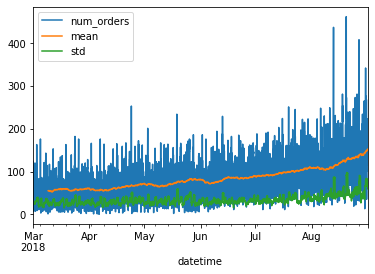

In [7]:
data['mean'] = data['num_orders'].rolling(200).mean() 
data['std'] = data['num_orders'].rolling(20).std()

data.plot()
del data['mean']
del data['std']

Также посмотрим на график разности и его скользящие значения

<AxesSubplot:xlabel='datetime'>

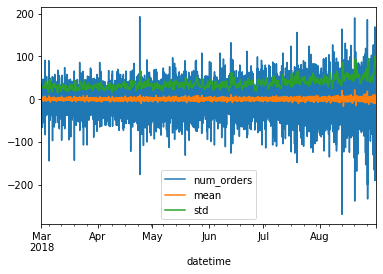

In [8]:
data_sub = data - data.shift()
data_sub['mean'] = data_sub['num_orders'].rolling(20).mean() 
data_sub['std'] = data_sub['num_orders'].rolling(20).std()

data_sub.plot()

Видно, что среднее постепенно увеличивается, что говорит о том, что ряд нестационарный и прогнозировать его будет сложнее.<br>

Если посмотреть на график разности, то видно, что ряд стал более стационарным, его среднее почти не изменяется, стандартное отклонение немного увеличивается. Что говорит о возможности прогнозирования<br>

Посмотрим на компоненты: тренд, сезонная и остаток:

In [9]:
decomposed = seasonal_decompose(data) 

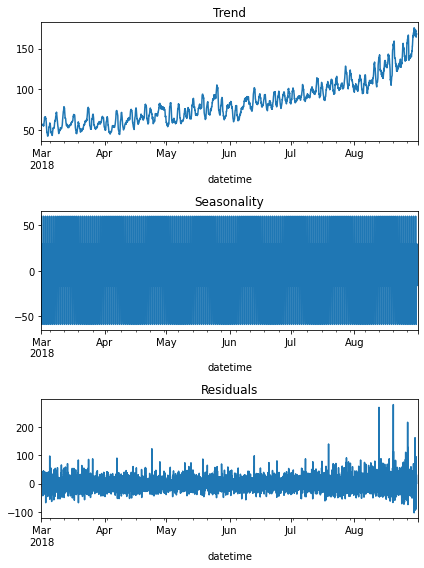

In [10]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Трендовая компонента ведет себя как среднее - постепенно увеличивается, возможно, это связано с тем, что сервис стал более популярный или, например, из-за того, что в августе-сентябре многие люди любят летать на отдых, а в это время наибольшее количество отпусков и каникул.

Сезонная компонента - не понтяна, надо рассмотреть её в меньшем диапозоне времени.

Остатки необъяснимы.

Text(0.5, 1.0, 'Seasonality')

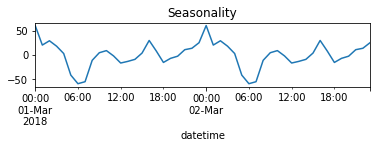

In [11]:
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')

Из графиков видно, что пик загруженности примерно в начале суток, а минимум в 7 часов утра

## Оценка модели

Разобьем данные на обучающую и тестовую выборки:

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

Оценим модель средним значением:

In [13]:
pred_mean = np.ones(train.shape) * train['num_orders'].mean()

print("RMSE:", mean_squared_error(train, pred_mean) ** 0.5)

RMSE: 38.66694570860161


Оценим модель медианой:

In [14]:
pred_median = np.ones(train.shape) * train['num_orders'].median()

print("RMSE:", mean_squared_error(train, pred_median) ** 0.5)

RMSE: 38.806713291350775


Оценим модель предыдущим значением ряда:

In [15]:
pred_previous = train.shift()
pred_previous.iloc[[0]] = train.iloc[[1]]

print("RMSE:", mean_squared_error(train, pred_previous) ** 0.5)

RMSE: 36.14599513456145


Значение метрики чуть больше 36. Попробуем добиться лучшего результата.

## Обучение моделей

Напишем функцию, которая будет создавать новые признаки:

- Месяц
- День
- День недели
- Предыдущие показатели целевого признака
- Скользящее среднее (не включающие в себя значение целевого признака)

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['lag_1'].rolling(rolling_mean_size).mean()
    
    return new_data

In [17]:
data = make_features(data, 30, 20)

In [18]:
data.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим пропуски

In [19]:
data = data.dropna()

Измененный датасет разделим на выборки:

In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

Выделим целевой признак:

In [21]:
train_target = train['num_orders']
train_features = train.drop(['num_orders'], axis=1)

test_target = test['num_orders']
test_features = test.drop(['num_orders'], axis=1)

**Линейная регрессия**

In [22]:
model = LinearRegression()

scores = cross_val_score (
    model, 
    train_features, 
    train_target, 
    cv=TimeSeriesSplit(n_splits=10).split(train_features),
    scoring='neg_root_mean_squared_error'
)

final_score = - sum(scores) / len(scores)
print(final_score)

25.92006124419961


**Случайный лес**

In [23]:
clf = RandomForestRegressor()

parametrs = { 'n_estimators': range (20, 150, 20),
              'max_depth': range (1,15, 2)
            }

grid = GridSearchCV(clf, parametrs, cv=TimeSeriesSplit(n_splits=2).split(train_features), scoring='neg_root_mean_squared_error')
grid.fit(train_features, train_target)



GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fb454b82900>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'n_estimators': range(20, 150, 20)},
             scoring='neg_root_mean_squared_error')

In [24]:
grid.best_params_

{'max_depth': 13, 'n_estimators': 120}

In [25]:
model = RandomForestRegressor (
    n_estimators = 120,
    max_depth = 13,
    random_state = 12345
)

scores = cross_val_score (
    model, 
    train_features, 
    train_target, 
    cv=TimeSeriesSplit(n_splits=10),
    scoring='neg_root_mean_squared_error'
)

final_score = - sum(scores) / len(scores)
print(final_score)

24.7181470875098


**CatBoost**

In [26]:
clf = CatBoostRegressor(verbose=0)

parametrs = { 
    'iterations' : range(140, 151, 10),
    'learning_rate': np.arange (0.5,1, 0.2)
}

grid = GridSearchCV(clf, parametrs, cv=TimeSeriesSplit(n_splits=2), scoring='neg_root_mean_squared_error')
grid.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb453a0c7f0>,
             param_grid={'iterations': range(140, 151, 10),
                         'learning_rate': array([0.5, 0.7, 0.9])},
             scoring='neg_root_mean_squared_error')

In [27]:
grid.best_params_

{'iterations': 140, 'learning_rate': 0.5}

In [28]:
model = CatBoostRegressor (
    iterations = 140,
    learning_rate = 0.5,
    verbose = 0,
    random_seed = 12345,
)

scores = cross_val_score (
    model, 
    train_features, 
    train_target, 
    cv=TimeSeriesSplit(n_splits=10),
    scoring='neg_root_mean_squared_error'
)

In [29]:
final_score = - sum(scores) / len(scores)
print(final_score)

26.248167031186163


**Вывод:** лучшая модель - RandomForestRegressor

## Проверка модели

Проверим лучшую модель на тестовой выборке

In [30]:
model = RandomForestRegressor (
    n_estimators = 140,
    max_depth = 13,
    random_state = 12345
)

model.fit(train_features, train_target)
predictions = model.predict(test_features)

rmse = mean_squared_error(predictions, test_target) ** 0.5
print(rmse)

43.56634265490669


Посмотрим на графики исходного и предсказанных рядов.

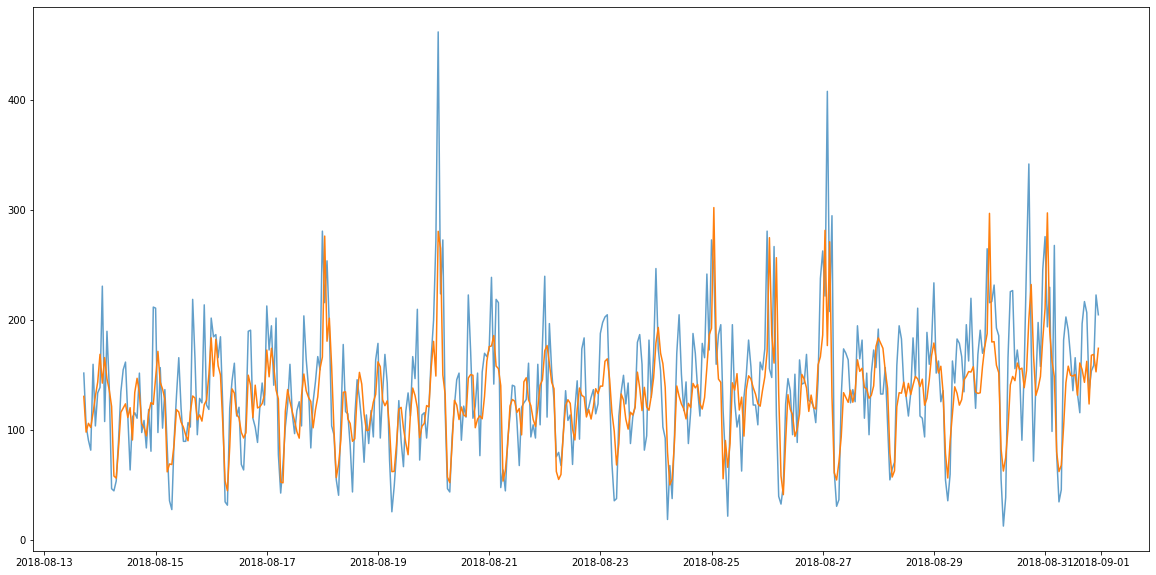

In [31]:
pred = pd.Series(predictions, index=test_target.index)

plt.figure(figsize=(20,10))
plt.plot(test_target, alpha=0.7)
plt.plot(pred)
plt.show()

## Вывод

В данном проекте было необходимо научиться прогнозировать количество заказов такси на следующий час. И построить модель для такого предсказания со значением метрики RMSE не больше 48.

В первую очередь были проанализированы данные. Далее была оценена модель предсказания по нашей метрике, мы получили значение - 36 при прогнозировании предыдущим значением.

Далее рассмтривались три модели: **LinearRegression, RandomForestRegressor, CatBoost.** <br>

Лучшая модель по метрике **RMSE** оказалась: **RandomForestRegressor**. (rmse = 23.452797840380203) <br>
Значение метрки на тестовой выборке: 43.56634265490669   <br> 

Итоговое значение метрики не больше 48.